In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import glob
import fasttext
import pickle
import numpy as np
import matplotlib.pyplot as plt
from preprocess import DatasetPreprocess
from CustomModel import Model
from sklearn.model_selection import train_test_split
import csv
from pprint import pprint
import pickle
import random
import torch

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed()

### Reading the entire dataset

In [42]:
read_full_dataset = True

In [43]:
with open('/StudentData/Project/ind_tokenizer.pkl', 'rb') as f:
    ind_to_label_mapper = pickle.load(f)
label_to_ind_mapper = {f"__label__{value}": key for key, value in ind_to_label_mapper.items()}

if read_full_dataset:
    all_files = glob.glob("/StudentData/Project/data_chunk_*.csv")

    li = []


    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0, usecols=['text','industry', 'lang'])
        df['industry'] = df['industry'].apply(lambda x: label_to_ind_mapper[x])
        li.append(df)

    frame = pd.concat(li, axis=0, ignore_index=True)

In [44]:
full_ds = frame

In [45]:
frame = frame[frame['lang'] == 'en']

In [46]:
frame

,industry,text,lang
0,marketing and advertising,1 5 View Your Account Our online Member Accoun...,en
1,environmental services,"In that time, our company has built our reput...",en
2,management consulting,Home About Services Clients Mentoring Testimo...,en
3,civil engineering,Banks Passive Park Clients Contact (901) 384-...,en
4,accounting,and for the future you want A full range of ac...,en
...,...,...,...
1700019,apparel & fashion,0 Center Concept Eclipse Focus Image Kross Rog...,en
1700020,entertainment,Staffing Undercover Productions Las Vegas Unde...,en
1700021,hospital & health care,"Posted by OBS on Jul 5, 2013 The staff at Opt...",en
1700022,music,QR check-ins upon entry are mandatory.2. Mask...,en


### Keep only the 5 most and least frequent industries (with more than 1000 records)

In [49]:
frame['id'] = frame.index + 1
n_industries = 5
lower_limit = 1000
grouped = frame.groupby('industry').count()[['id']].rename({'id': 'count'}, axis='columns').sort_values('count')
grouped = grouped[grouped['count'] > lower_limit]

grouped_edges = pd.concat([grouped.head(n_industries), grouped.tail(n_industries)])

to_keep_indstries = grouped_edges.index
frame = frame[frame['industry'].isin(to_keep_indstries)]

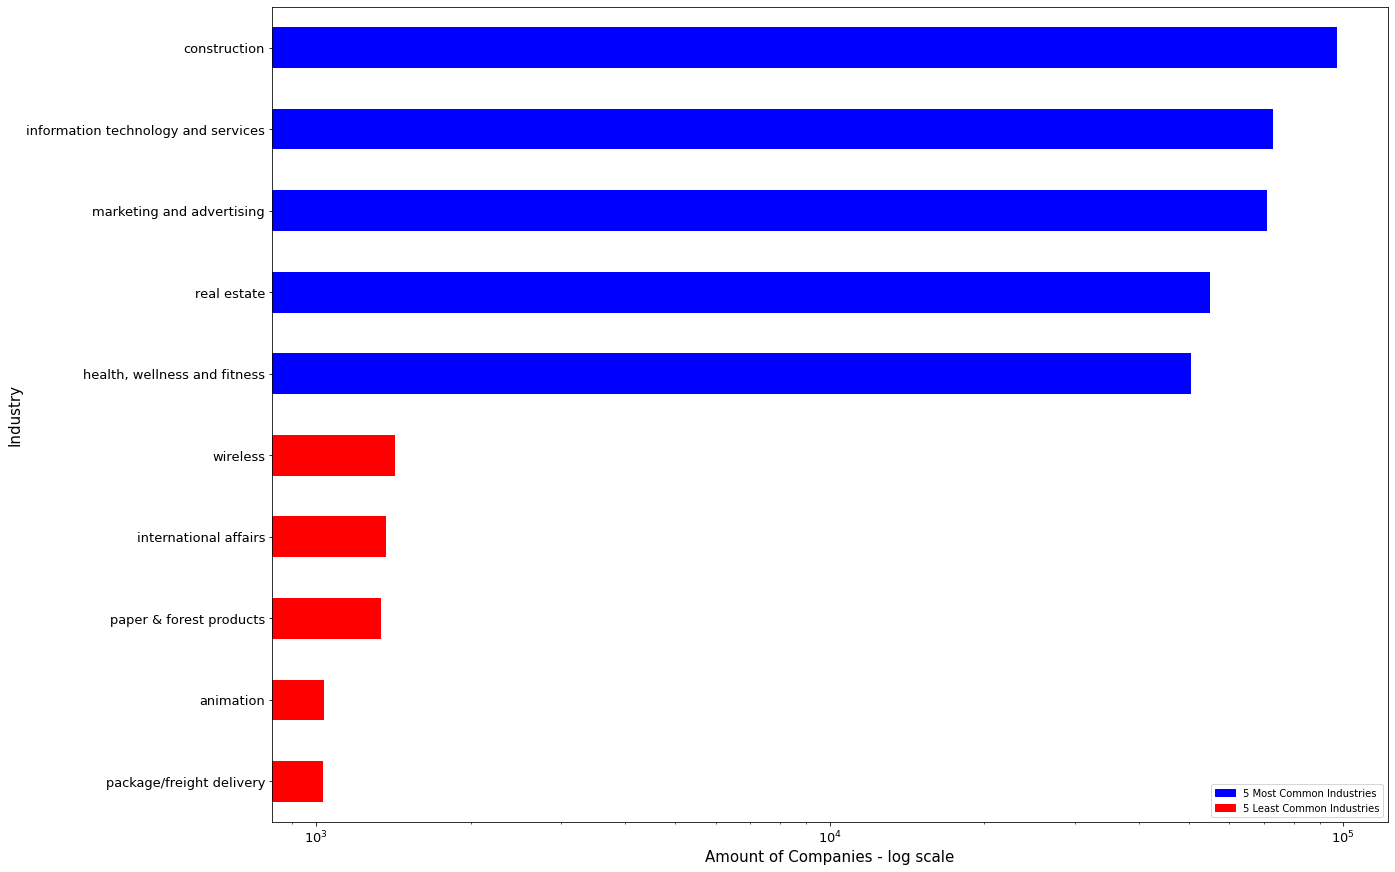

In [51]:
ax = grouped_edges['count'].plot(kind='barh', logx=True, color =['r']*n_industries+['b']*n_industries, figsize=(20, 15), fontsize=13)
colors = {'5 Most Common Industries':'blue', '5 Least Common Industries':'red'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
ax.legend(handles, labels)
ax.set_xlabel('Amount of Companies - log scale', fontsize=15)
ax.set_ylabel('Industry', fontsize=15);

In [52]:
ten_ind_mapper = {f"__label__{key}": value for key, value in enumerate(grouped_edges.index)}
ind_ten_mapper = {value: key for key, value in ten_ind_mapper.items()}

print("ten_ind_mapper:")
pprint(ten_ind_mapper)
print("\nind_ten_mapper:")
pprint(ind_ten_mapper)

frame['industry'] = frame['industry'].apply(lambda x: ind_ten_mapper[x])
frame = frame.reset_index(drop=True)
frame


ten_ind_mapper:
{'__label__0': 'package/freight delivery',
 '__label__1': 'animation',
 '__label__2': 'paper & forest products',
 '__label__3': 'international affairs',
 '__label__4': 'wireless',
 '__label__5': 'health, wellness and fitness',
 '__label__6': 'real estate',
 '__label__7': 'marketing and advertising',
 '__label__8': 'information technology and services',
 '__label__9': 'construction'}

ind_ten_mapper:
{'animation': '__label__1',
 'construction': '__label__9',
 'health, wellness and fitness': '__label__5',
 'information technology and services': '__label__8',
 'international affairs': '__label__3',
 'marketing and advertising': '__label__7',
 'package/freight delivery': '__label__0',
 'paper & forest products': '__label__2',
 'real estate': '__label__6',
 'wireless': '__label__4'}


,industry,text,lang,id
0,__label__7,1 5 View Your Account Our online Member Accoun...,en,1
1,__label__6,Michigan Big Rapids MI 49307 (231) 250-9802 (...,en,6
2,__label__7,Is it Time to Shake-up Your Marketing Strateg...,en,20
3,__label__9,com HOMEWHY CHOOSE DMH INTERIORS LTD?KEY PEOPL...,en,22
4,__label__6,We ve been in our place about 5 months and en...,en,23
...,...,...,...,...
353283,__label__7,"Commerce St., Ste 104, Wichita, Kansas 67202F...",en,1699987
353284,__label__9,Safe Logic currently has a range of experienc...,en,1699994
353285,__label__5,com Facebook RSS Facebook RSS Reviews Resource...,en,1700006
353286,__label__5,The days are getting shorter & cooler & over ...,en,1700008


In [71]:
ind_size_dict = {ind_ten_mapper[ind]: size for ind, size in grouped_edges['count'].iteritems()}
d = {key: [ten_ind_mapper[key], ind_size_dict[key]] for key in ten_ind_mapper.keys()}
df = pd.DataFrame.from_dict(d, orient='index', columns=['industry', 'size']).reset_index().rename({'index': 'label'}, axis=1)
df.to_csv('/StudentData/Project/ten_ind_mapper.csv', index=False)
df

,label,industry,size
0,__label__0,package/freight delivery,1031
1,__label__1,animation,1035
2,__label__2,paper & forest products,1340
3,__label__3,international affairs,1370
4,__label__4,wireless,1427
5,__label__5,"health, wellness and fitness",50568
6,__label__6,real estate,54995
7,__label__7,marketing and advertising,71096
8,__label__8,information technology and services,73053
9,__label__9,construction,97373


## Rum from here to use saved data

In [4]:
# with open('/StudentData/Project/10_classes_data.pkl', 'wb') as f:
#     pickle.dump(frame, f)
    
frame = pd.read_pickle('/StudentData/Project/processed_train.pkl')
    
mapper_df = pd.read_csv('/StudentData/Project/ten_ind_mapper.csv')

In [5]:
ten_ind_mapper = mapper_df[['label', 'industry']].set_index('label')['industry'].to_dict()
ind_ten_mapper = {value: key for key, value in ten_ind_mapper.items()}
ind_size_dict = mapper_df[['label', 'size']].set_index('label')['size'].to_dict()


print("ten_ind_mapper:")
pprint(ten_ind_mapper)
print("\nind_ten_mapper:")
pprint(ind_ten_mapper)
print("\nind_size_dict:")
pprint(ind_size_dict)

ten_ind_mapper:
{'__label__0': 'package/freight delivery',
 '__label__1': 'animation',
 '__label__2': 'paper & forest products',
 '__label__3': 'international affairs',
 '__label__4': 'wireless',
 '__label__5': 'health, wellness and fitness',
 '__label__6': 'real estate',
 '__label__7': 'marketing and advertising',
 '__label__8': 'information technology and services',
 '__label__9': 'construction'}

ind_ten_mapper:
{'animation': '__label__1',
 'construction': '__label__9',
 'health, wellness and fitness': '__label__5',
 'information technology and services': '__label__8',
 'international affairs': '__label__3',
 'marketing and advertising': '__label__7',
 'package/freight delivery': '__label__0',
 'paper & forest products': '__label__2',
 'real estate': '__label__6',
 'wireless': '__label__4'}

ind_size_dict:
{'__label__0': 1031,
 '__label__1': 1035,
 '__label__2': 1340,
 '__label__3': 1370,
 '__label__4': 1427,
 '__label__5': 50568,
 '__label__6': 54995,
 '__label__7': 71096,
 '__labe

In [11]:
test_ds = pd.read_pickle('/StudentData/Project/processed_test.pkl')

**Keeping test aside to evaluate all models**

In [12]:
# X_train, X_test, y_train, y_test = train_test_split(frame[['text']], frame[['industry']], test_size=0.15, random_state=42)

In [16]:
# test_ds = pd.concat([X_test, y_test], axis=1)
# fasttext_test_file_path='/StudentData/Project/processed_test.txt'
# test_ds.to_csv(fasttext_test_file_path,
#                 index=False,
#                 sep=' ',
#                 header=None,
#                 quoting=csv.QUOTE_NONE,
#                 quotechar="",
#                 escapechar=" ")

In [17]:
# test_ds.to_pickle('/StudentData/Project/processed_test.pkl')

In [18]:
# frame = pd.concat([X_train, y_train], axis=1)

In [19]:
# frame.to_pickle('/StudentData/Project/processed_train.pkl')

## Evaluating fasttext model using the regular dataset

In [12]:
def train_model(train_df, fasttext_train_file_path, save_model_path=None):
    print("started writing train file")
    train_df.to_csv(fasttext_train_file_path,
                    index=False,
                    sep=' ',
                    header=None,
                    quoting=csv.QUOTE_NONE,
                    quotechar="",
                    escapechar=" ")

    model_params = {'dim': 90, 'epoch': 14, 'lr': 0.05, 'lrUpdateRate': 100, 'maxn': 0, 'minCount': 1, 'minn': 0,
                    'neg': 5, 't': 0.0001, 'thread': 12, 'verbose': 2, 'ws': 5}
    model = Model(model_params)
    print('started training')
    model.train(fasttext_train_file_path, save_model_path=save_model_path)
    print('finished training')

    return model


def evaluate_model(model, test_df, ind_size_dict, method=None):
    y_pred = model.predict(texts=test_df['text'])
    f1_dict = {}
    f1_dict['micro'] = model.calc_f1(test_ds['industry'], y_pred, 'micro')
    f1_dict['macro'] = model.calc_f1(test_ds['industry'], y_pred, 'macro')
    f1_dict['weighted'] = model.calc_f1(test_ds['industry'], y_pred, 'weighted')
    
    for avg, f1 in f1_dict.items():
        print(f"f1_{avg}: ", round(f1, 3))

    sensitivities = {}
    sizes = []
    for industry in sorted(ind_size_dict.keys()):
        sensitivity_per_ind = model.sensitivity_per_ind(industry, test_ds['industry'], y_pred)
        print("Sensetivity for", industry, ':', round(sensitivity_per_ind, 3), ' \tThe size is:',
              ind_size_dict[industry])
        sensitivities[industry] = sensitivity_per_ind
        sizes.append(ind_size_dict[industry])

    sizes = np.array(list(ind_size_dict.values()))
    
    fig, ax = plt.subplots(figsize=(7.5, 5))
    ax.scatter(np.log(np.array(sizes)), sensitivities.values())
    ax.set_ylim((-0.1, 1.1))
    ax.set_xlabel('Amount of Records in Industry - log scale')
    ax.set_ylabel('Sensitivity')
    ax.set_title(f'Sensetivity Per Industry - {method}');
    return f1_dict, sensitivities

f1_micro:  0.858
f1_macro:  0.579
f1_weighted:  0.854
Sensetivity for __label__0 : 0.098  	The size is: 1031
Sensetivity for __label__1 : 0.154  	The size is: 1035
Sensetivity for __label__2 : 0.301  	The size is: 1340
Sensetivity for __label__3 : 0.242  	The size is: 1370
Sensetivity for __label__4 : 0.194  	The size is: 1427
Sensetivity for __label__5 : 0.893  	The size is: 50568
Sensetivity for __label__6 : 0.845  	The size is: 54995
Sensetivity for __label__7 : 0.852  	The size is: 71096
Sensetivity for __label__8 : 0.832  	The size is: 73053
Sensetivity for __label__9 : 0.913  	The size is: 97373


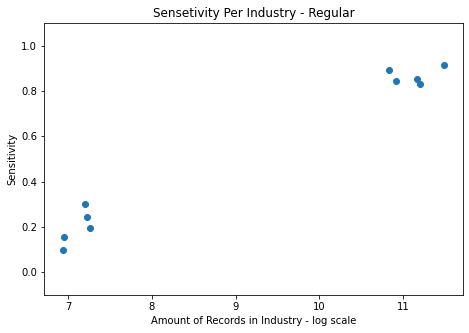

In [107]:
set_seed()

fasttext_train_file_path='/StudentData/Project/Regular/regular_processed_train.txt'
save_model_path = '/StudentData/Project/Regular/regular_model.pth'

model_reg = train_model(frame, fasttext_train_file_path, save_model_path=None)

f1_reg, sensitivities_reg = evaluate_model(model_reg, test_ds, ind_size_dict, 'Regular')

## Undersampling

In [11]:
num_samples_undersample = min(ind_size_dict.values())
num_samples_undersample

1031

In [12]:
def undersample(df: pd.DataFrame, threshold: int, seed: int):
    final_dfs_list = []
    for industry in df.industry.unique():
        temp_df = df[df['industry'] == industry]
        if len(temp_df) > threshold:
            temp_df = temp_df.sample(threshold, random_state=seed)
        final_dfs_list.append(temp_df)
    final_df = pd.concat(final_dfs_list)
    return final_df

In [13]:
undersample_df = undersample(frame, num_samples_undersample, 42)

f1_micro:  0.221
f1_macro:  0.123
f1_weighted:  0.239
Sensetivity for __label__0 : 0.0  	The size is: 1031
Sensetivity for __label__1 : 0.207  	The size is: 1035
Sensetivity for __label__2 : 0.122  	The size is: 1340
Sensetivity for __label__3 : 0.89  	The size is: 1370
Sensetivity for __label__4 : 0.0  	The size is: 1427
Sensetivity for __label__5 : 0.103  	The size is: 50568
Sensetivity for __label__6 : 0.013  	The size is: 54995
Sensetivity for __label__7 : 0.6  	The size is: 71096
Sensetivity for __label__8 : 0.166  	The size is: 73053
Sensetivity for __label__9 : 0.16  	The size is: 97373


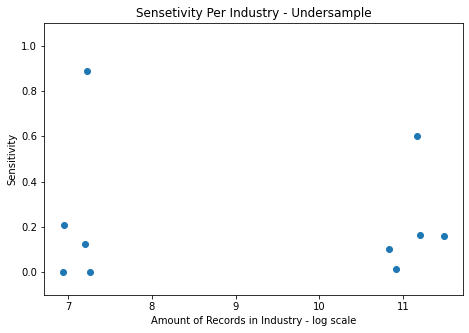

In [108]:
set_seed()
fasttext_train_file_path='/StudentData/Project/Undersampled/undersample_processed_train.txt'
save_model_path = '/StudentData/Project/Undersampled/undersample_model.pth'

model_undersample = train_model(undersample_df, fasttext_train_file_path, save_model_path=None)

f1_undersample, sensitivities_undersample = evaluate_model(model_undersample, test_ds, ind_size_dict, 'Undersample')

## Oversampling

In [15]:
num_samples_oversample = max(ind_size_dict.values())
num_samples_oversample

97373

In [16]:
def oversample(df: pd.DataFrame, threshold: int, seed: int):
    final_dfs_list = []
    for industry in df.industry.unique():
        temp_df = df[df['industry'] == industry]
        if len(temp_df) < threshold:
            temp_df = temp_df.sample(threshold, random_state=seed, replace=True)
        final_dfs_list.append(temp_df)
    final_df = pd.concat(final_dfs_list)
    return final_df

In [17]:
oversample_df = oversample(frame, num_samples_oversample, 42)

f1_micro:  0.845
f1_macro:  0.644
f1_weighted:  0.847
Sensetivity for __label__0 : 0.613  	The size is: 1031
Sensetivity for __label__1 : 0.456  	The size is: 1035
Sensetivity for __label__2 : 0.622  	The size is: 1340
Sensetivity for __label__3 : 0.564  	The size is: 1370
Sensetivity for __label__4 : 0.495  	The size is: 1427
Sensetivity for __label__5 : 0.889  	The size is: 50568
Sensetivity for __label__6 : 0.838  	The size is: 54995
Sensetivity for __label__7 : 0.845  	The size is: 71096
Sensetivity for __label__8 : 0.798  	The size is: 73053
Sensetivity for __label__9 : 0.881  	The size is: 97373


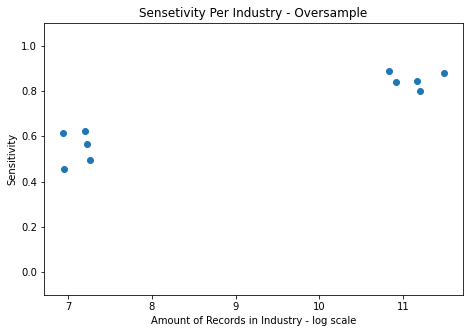

In [109]:
set_seed()
fasttext_train_file_path='/StudentData/Project/Oversampled/oversample_processed_train.txt'
save_model_path = '/StudentData/Project/Oversampled/oversample_model.pth'

# model_oversample = train_model(oversample_df, fasttext_train_file_path, save_model_path=None)

f1_oversample, sensitivities_oversample = evaluate_model(model_oversample, test_ds, ind_size_dict, 'Oversample')

# Working with generated data

In [18]:
with open('/StudentData/Project/Generative/GeneratedOutputs/generated_list_0.pkl', 'rb') as f:
    generated_list_0 = pickle.load(f)

In [21]:
def concat_generated_date(df: pd.DataFrame, generated_dict):
    final_dfs_list = [df.copy()]
    for ind_num, generated_list in generated_dict.items():
        temp_generated_df = pd.DataFrame({'text': generated_list, 'industry': [f'__label__{ind_num}']*len(generated_list)})
        final_dfs_list.append(temp_generated_df)
    final_df = pd.concat(final_dfs_list)
    return final_df

In [24]:
generated_dict = {'0': generated_list_0}
generated_df = concat_generated_date(frame, generated_dict)

In [25]:
generated_df

,text,industry
123349,office Live YES Program Resources Blog IT Lunc...,__label__8
294352,Arrive High-Five How Do You Create an Exceptio...,__label__6
79074,We get I Tso you don't have to. Homeduckonwat...,__label__8
198827,00 Next-Level Digital Marketing Buzz. Engageme...,__label__7
40337,Search By Nearby Me SEARCH: All Cities Neighb...,__label__6
...,...,...
37879,freight delivery is a business that focuses on...,__label__0
37880,package freight delivery. storage services - s...,__label__0
37881,"agri trail coop main st hope k grain. elma, ka...",__label__0
37882,international mover specializes in the deliver...,__label__0


f1_micro:  0.858
f1_macro:  0.612
f1_weighted:  0.855
Sensetivity for __label__0 : 0.472  	The size is: 1031
Sensetivity for __label__1 : 0.172  	The size is: 1035
Sensetivity for __label__2 : 0.281  	The size is: 1340
Sensetivity for __label__3 : 0.207  	The size is: 1370
Sensetivity for __label__4 : 0.175  	The size is: 1427
Sensetivity for __label__5 : 0.892  	The size is: 50568
Sensetivity for __label__6 : 0.846  	The size is: 54995
Sensetivity for __label__7 : 0.848  	The size is: 71096
Sensetivity for __label__8 : 0.833  	The size is: 73053
Sensetivity for __label__9 : 0.913  	The size is: 97373


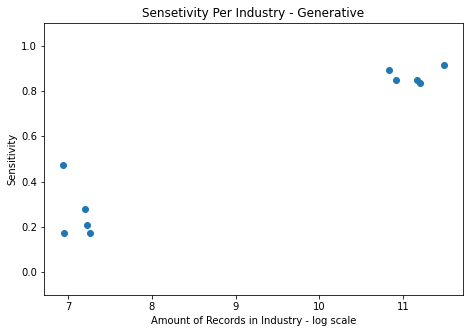

In [28]:
set_seed()

fasttext_train_file_path='/StudentData/Project/Generative/generated_processed_train.txt'
save_model_path = '/StudentData/Project/Generative/generated_model.pth'

model_generated = train_model(generated_df, fasttext_train_file_path, save_model_path=None)

f1_generated, sensitivities_generated = evaluate_model(model_generated, test_ds, ind_size_dict, 'Generative')

## Comparing results from all models

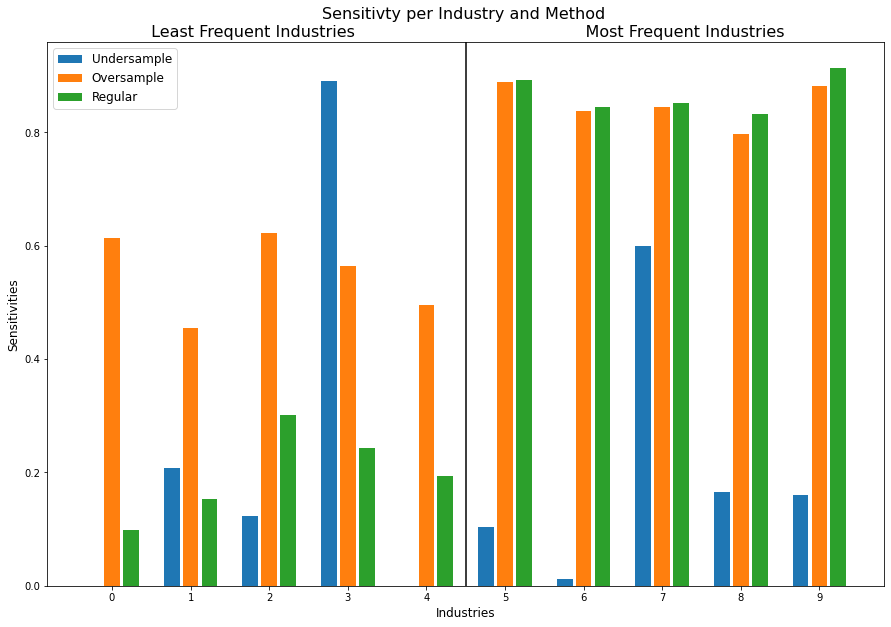

In [158]:
x = np.arange(10)
y1 = sensitivities_undersample.values()
y2 = sensitivities_oversample.values()
y3 = sensitivities_reg.values()
width = 0.2

fig, ax = plt.subplots(figsize=(15,10))
# plot data in grouped manner of bar type
ax.bar(x-0.24, y1, width, label='Undersample')
ax.bar(x, y2, width, label='Oversample')
ax.bar(x+0.24, y3, width, label='Regular')
ax.set_xticks(x)
ax.set_xlabel("Industries", fontsize=12)
ax.set_ylabel("Sensitivities", fontsize=12)
ax.set_title('Sensitivty per Industry and Method \n Least Frequent Industries                                             Most Frequent Industries', fontsize=16)

ax.legend(fontsize=12)
ax.axvline(x=4.5, color='black')
plt.show()

In [193]:
f1_df = pd.DataFrame([f1_reg, f1_undersample, f1_oversample])
f1_df['method'] = pd.Series(['Regular', 'Undersample', 'Oversample'])
f1_df = f1_df.set_index('method')


In [191]:
f1_df

,micro,macro,weighted
method,,,
Regular,0.857607,0.579228,0.853960
Undersample,0.220817,0.122867,0.238882
Oversample,0.844945,0.644225,0.846936


Text(0.5, 1.0, 'Micro, Macro and Weighted F1 Scores per Method')

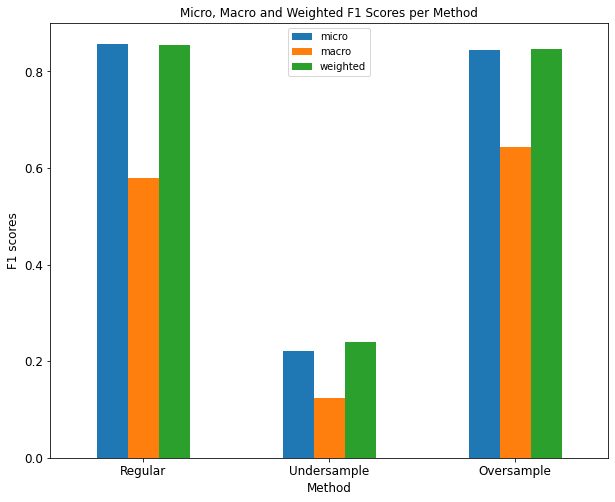

In [192]:
ax = f1_df.plot.bar(rot=0, figsize=(10, 8), fontsize=12)
ax.set_xlabel('Method', fontsize=12)
ax.set_ylabel('F1 scores', fontsize=12)
ax.set_title('Micro, Macro and Weighted F1 Scores per Method');